<h1 style="text-align:center;font-size:40px;">Tools 1 Final Project</h1>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<p style="text-align:center;">Anthony Molieri<br>
Leo Walker</p>
<br>
<br>
<br>
<br>

# Dataset and Motivation

The data used for these analyses were scraped from Indeed and Glassdoor. The data from Indeed contains job descriptions for open Data Scientist positions. The Glassdoor data includes employee generated ratings on benefits and perks for many of the companies present in the Indeed dataset. The datasets were then combined in order to give an idea of how employees rank the benefits at these companies.

*The Indeed data was scraped over ... pulling job descriptions for Data Scientists in 25 cities throughout the US. **Leo** Add Correct Details, here about the Indded data and scraper*

The Glassdoor scraper was designed to pull company names from the the job description dataset. It then looped over the list of employers, searched, and scraped ratings from the benefits page for companies that were found. This data was then added to it's own table in the same database. The scraper was designed to be run multiple times, only searching for benefits ratings that were not already present in the database. 

# Task Definition and Research Question
 
The purpose of this project was to help give a better idea of how employees at companies with open positions rate their benefits. This can help give insight into how desirable a company is as an employer.

# Literature Review

*Add -- I'm not really sure what to add here. Maybe something about turnover in data science? Companies not having great benefits?*

# Data Cleaning

In [1]:
# imports
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Initialize both tables
cnct = sqlite3.connect('Data/jobs')

indeed_df = pd.read_sql_query('SELECT * FROM indeed_jobs;', cnct)

glassdoor_df = pd.read_sql_query('SELECT companies, type, rating, count_of_ratings FROM ratings;', cnct)

## Cleaning Indeed Data

In [3]:
# # Pull missing salary data from description

# I'm not great at regex but let's try this
# Only look for salary data when it's missing in 'est_salary'
# this big regex creates an array of text, the first item is the most accurate. 
indeed_df['salary_extract'] = np.where(indeed_df['est_salary'] == "No Estimated Salary",indeed_df['job_desc'].str.extract("((\$)(([0-9])([0-9])([0-9])(,)([0-9])([0-9])([0-9])|([0-9])([0-9])(,)([0-9])([0-9])([0-9]))( to |-| - )(\$|)(([0-9])([0-9])([0-9])(,)([0-9])([0-9])([0-9])|([0-9])([0-9])(,)([0-9])([0-9])([0-9]))|(\$)([0-9][0-9][0-9],[0-9][0-9][0-9])|(\$)([0-9][0-9],[0-9][0-9][0-9]))")[0], np.NaN)

In [4]:

indeed_df.head()

,index,job_title,company_name,company_location,est salary,job_href,job_desc,est_salary,retrieve_date,salary_extract
0,0,Data Scientist,Visa,"Atlanta, GA+1 location",None,https://www.indeed.com/rc/clk?jk=160fbb9ff7748...,Company Description Visa is a world leader in ...,No Estimated Salary,2022-02-06,NaN
1,1,Data Scientist and Analytics Specialist,Delta,"Atlanta, GA+4 locations",None,https://www.indeed.com/rc/clk?jk=9b1cc6670b2a1...,"United States, Georgia, Atlanta Product Manage...",No Estimated Salary,2022-02-06,NaN
2,2,Data Scientist,Morgan Stanley,"Alpharetta, GA+1 location",None,https://www.indeed.com/rc/clk?jk=09cd279af0796...,Data Scientist Job Number: 3199911 POSTING DA...,No Estimated Salary,2022-02-06,NaN
3,3,"Data Scientist, Mid",Booz Allen Hamilton,"Atlanta, GA 30303 (Downtown area)",None,https://www.indeed.com/rc/clk?jk=94388bcf3050b...,Key Role: Apply broad understanding of the pri...,No Estimated Salary,2022-02-06,NaN
4,4,Data Scientist,JBT,"Alpharetta, GA",None,https://www.indeed.com/rc/clk?jk=c198ebe89e917...,Overview Data Scientist We are a global leadin...,No Estimated Salary,2022-02-06,NaN


## Cleaning Glassdoor Data

In [5]:
# Restructure glassdoor data

# split type and sub-type
glassdoor_df[['new_type', 'sub_type']] = glassdoor_df['type'].str.split(' - ', expand=True)
glassdoor_df.drop(['type'], axis=1, inplace=True)

glassdoor_df.head()

,companies,rating,count_of_ratings,new_type,sub_type
0,Visa,3.7,157,"Insurance, Health & Wellness",Health Insurance
1,Visa,3.6,21,"Insurance, Health & Wellness",Dental Insurance
2,Visa,3.6,18,"Insurance, Health & Wellness",Vision Insurance
3,Visa,3.4,13,"Insurance, Health & Wellness",Life Insurance
4,Visa,3.0,7,"Insurance, Health & Wellness",Health Savings Account (HSA)


In [6]:
# Get rid of text from ratings counts. The original parser wasn't made to handle language other than English
glassdoor_df['count_of_ratings'] = glassdoor_df['count_of_ratings'].str.extract('(\d+)', expand=False)

In [7]:
# get overall benefits scores
scaleScores = glassdoor_df.groupby(['companies', 'new_type']).apply(lambda x: (x["rating"].astype(float)* x["count_of_ratings"].astype(int)).sum() / x["count_of_ratings"].astype(int).sum())

scaleScores.head(5)

companies        new_type                    
-Social Native-  Insurance, Health & Wellness    1.000000
                 Perks & Discounts               5.000000
1-800 Contacts   Family & Parenting              3.487500
                 Financial & Retirement          3.800000
                 Insurance, Health & Wellness    3.463636
dtype: float64

In [8]:
# get mean count of ratings
countScore = glassdoor_df.groupby(['companies']).apply(lambda x: (x["count_of_ratings"].astype(int)).mean())

countScore.head(5)

companies
-Social Native-                       1.500000
1-800 Contacts                        2.483871
1199SEIU Benefit and Pension Funds    1.516129
1upHealth                             1.000000
22squared                             1.823529
dtype: float64

In [9]:
# Turn the calculated series' into dataframes that can be merged

# Scale Scores
scaleScore_temp = scaleScores.to_frame().reset_index()

scaleScore_df = scaleScore_temp.pivot_table(0, ['companies'], 'new_type')

scaleScore_df.reset_index( drop=False, inplace=True ) 
scaleScore_df.reindex(['companies', 'Family & Parenting', 'Financial & Retirement', 'Insurance, Health & Wellness', 'Perks & Discounts', 'Professional Support', 'Vacation & Time Off'], axis=1)

# Average of scores by
countScore_temp = countScore.to_frame().reset_index()
countScore_temp.rename(columns={0: "ratings_meanCount"}, inplace=True)

scaleScore_df = scaleScore_df.merge(countScore_temp, on='companies')

scaleScore_df

,companies,Family & Parenting,Financial & Retirement,"Insurance, Health & Wellness",Perks & Discounts,Professional Support,Vacation & Time Off,ratings_meanCount
0,-Social Native-,NaN,NaN,1.000000,5.000000,NaN,NaN,1.500000
1,1-800 Contacts,3.4875,3.800000,3.463636,4.140000,4.333333,3.363636,2.483871
2,1199SEIU Benefit and Pension Funds,2.7000,4.150000,2.857143,2.200000,2.000000,2.500000,1.516129
3,1upHealth,4.5000,2.000000,3.000000,3.000000,NaN,4.500000,1.000000
4,22squared,3.8000,2.725000,2.927273,3.333333,NaN,3.777778,1.823529
...,...,...,...,...,...,...,...,...
2343,pureIntegration,NaN,NaN,4.500000,NaN,NaN,NaN,2.000000
2344,the NBA,3.7500,3.800000,3.125000,3.484615,3.333333,2.400000,1.782609
2345,tunein,4.0000,NaN,3.000000,4.000000,NaN,NaN,1.000000
2346,us issworld,2.0000,2.500000,2.707692,NaN,1.000000,2.746667,3.200000


In [10]:
# Calculate a mean of all 6 categories
scaleScore_df['overall_mean'] = scaleScore_df[['Family & Parenting', 'Financial & Retirement', 'Insurance, Health & Wellness', 'Perks & Discounts', 'Professional Support', 'Vacation & Time Off']].mean(axis=1)

scaleScore_df.head(5)

,companies,Family & Parenting,Financial & Retirement,"Insurance, Health & Wellness",Perks & Discounts,Professional Support,Vacation & Time Off,ratings_meanCount,overall_mean
0,-Social Native-,NaN,NaN,1.000000,5.000000,NaN,NaN,1.500000,3.000000
1,1-800 Contacts,3.4875,3.800,3.463636,4.140000,4.333333,3.363636,2.483871,3.764684
2,1199SEIU Benefit and Pension Funds,2.7000,4.150,2.857143,2.200000,2.000000,2.500000,1.516129,2.734524
3,1upHealth,4.5000,2.000,3.000000,3.000000,NaN,4.500000,1.000000,3.400000
4,22squared,3.8000,2.725,2.927273,3.333333,NaN,3.777778,1.823529,3.312677


# Visualizations

### Look at benefits ratings generally

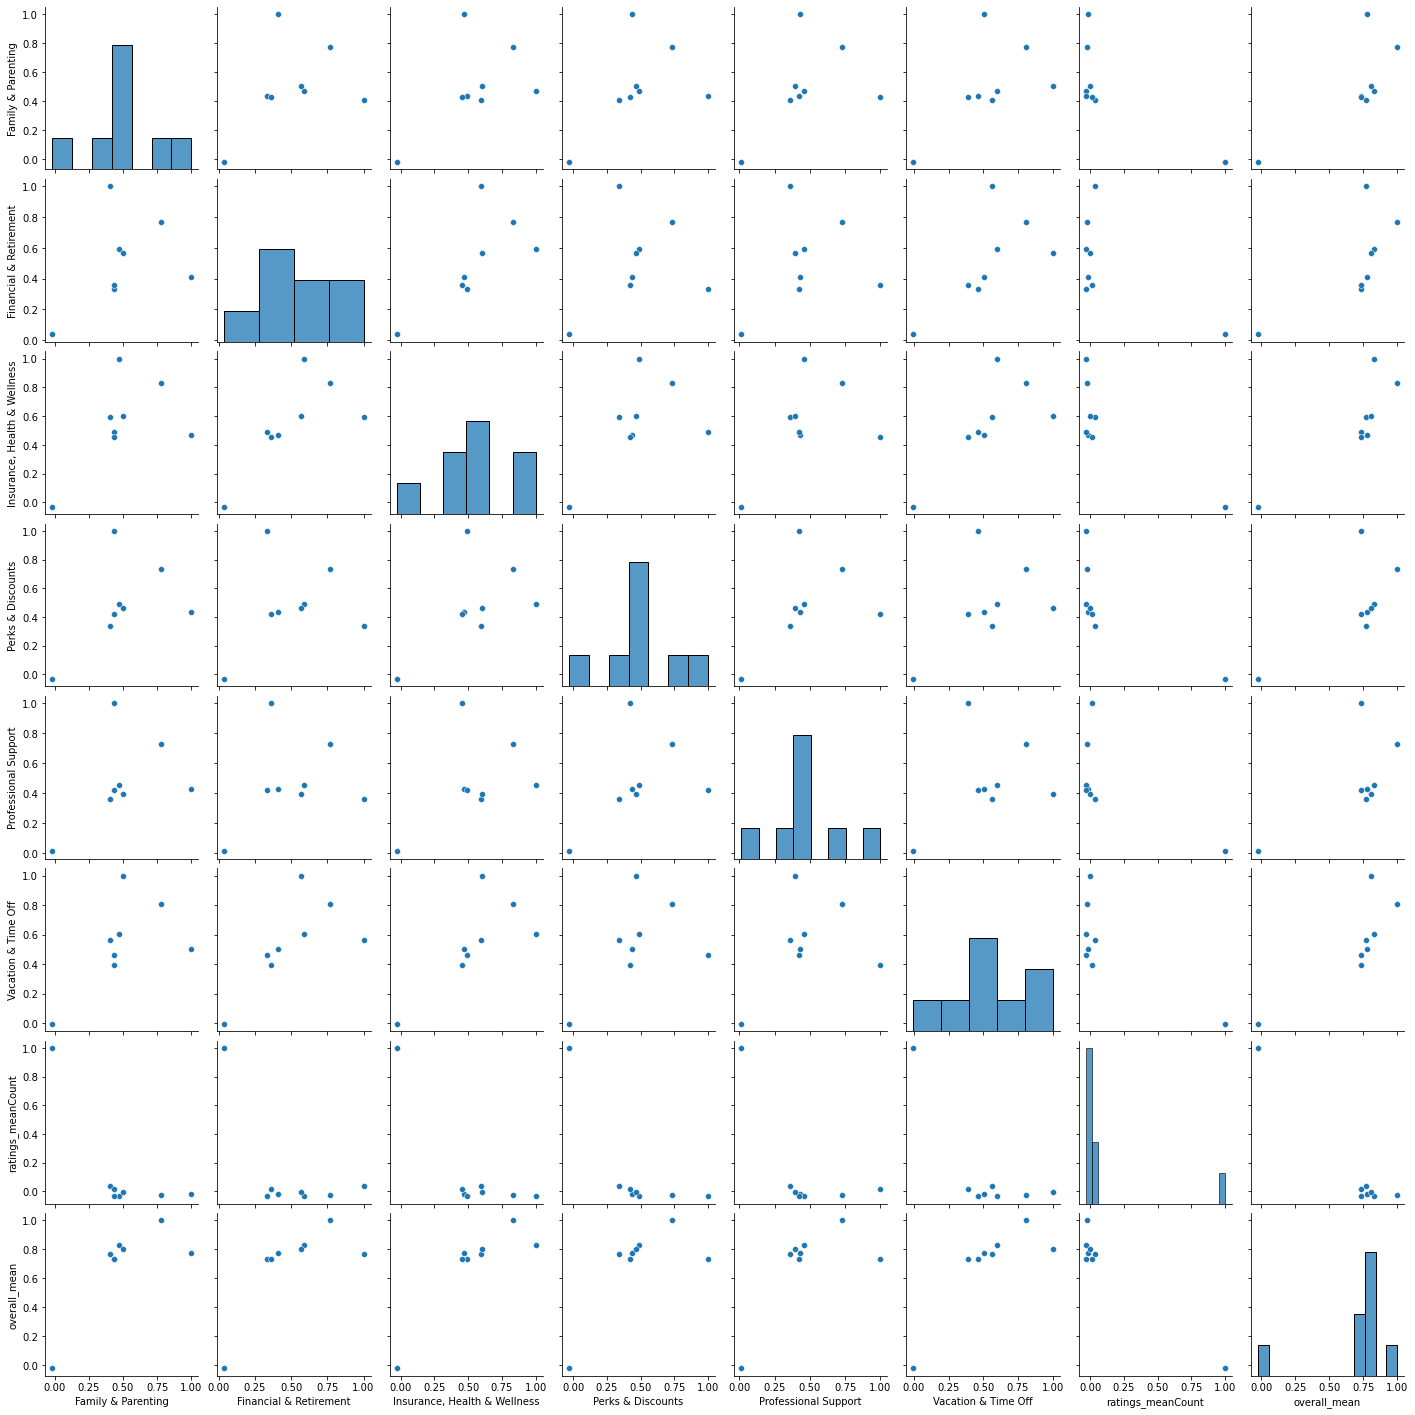

In [11]:
# Correlations on everything
sns.pairplot(scaleScore_df.corr())
plt.show()

In [12]:
# Let's only look at ratings with an average of 10 ratings per category
mostRated = scaleScore_df[scaleScore_df['ratings_meanCount'] >= 10].nlargest(10, 'overall_mean')

mostRated

,companies,Family & Parenting,Financial & Retirement,"Insurance, Health & Wellness",Perks & Discounts,Professional Support,Vacation & Time Off,ratings_meanCount,overall_mean
1978,The Hanover Insurance Group,5.000000,4.600000,4.300000,4.000000,NaN,4.800000,11.000000,4.540000
1723,Salesforce,4.733835,4.431048,4.582927,4.501852,4.100000,4.626250,27.666667,4.495985
900,Google,4.619463,4.601604,4.612454,4.659918,3.838462,4.388095,32.229167,4.453333
2069,UKG (Ultimate Kronos Group),4.632558,4.358273,4.484848,4.631250,4.063636,4.493694,16.157895,4.444043
1826,Southwest Airlines,4.273529,4.695477,4.358929,4.413115,4.547826,4.262376,15.837838,4.425209
1827,Southwest Airlines Co.,4.273529,4.695477,4.358929,4.413115,4.547826,4.262376,15.837838,4.425209
1392,New Relic,4.490909,3.880000,4.500000,5.000000,NaN,4.100000,11.000000,4.394182
189,AstraZeneca,4.206122,4.463235,4.035714,4.442857,4.800000,4.390909,10.260870,4.389806
160,Apple,4.555696,4.416726,4.486594,4.209366,4.284932,4.273571,62.913043,4.371147
1213,MIT,3.846429,4.390566,4.390977,4.087500,4.618182,4.350000,11.592593,4.280609


<AxesSubplot:>

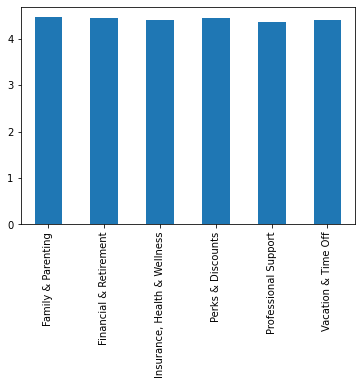

In [13]:
# Which benefit categories have the highest ratings?
mostRated[['Family & Parenting', 'Financial & Retirement', 'Insurance, Health & Wellness', 'Perks & Discounts', 'Professional Support', 'Vacation & Time Off']].mean().plot(kind='bar')

# All categories tend towards high ratings

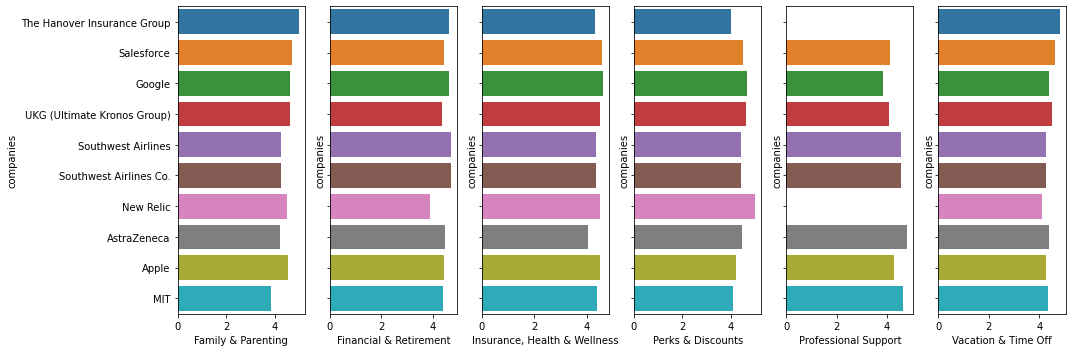

In [14]:
# Best Ratings by Category for the top 10 best rated companies
fig, ax = plt.subplots(ncols=6 , nrows=1, sharey=True, figsize=(15, 5))
sns.barplot(data=mostRated, x='Family & Parenting', y='companies', ax=ax[0])
sns.barplot(data=mostRated, x='Financial & Retirement', y='companies', ax=ax[1])
sns.barplot(data=mostRated, x='Insurance, Health & Wellness', y='companies', ax=ax[2])
sns.barplot(data=mostRated, x='Perks & Discounts', y='companies', ax=ax[3])
sns.barplot(data=mostRated, x='Professional Support', y='companies', ax=ax[4])
sns.barplot(data=mostRated, x='Vacation & Time Off', y='companies', ax=ax[5])
plt.tight_layout()
plt.show()

# Put into a joined barchart, but at the domain level there are clear differences

### Look at benefits ratings for companies 

In [15]:
# By companies with the most job postings

compCounts = indeed_df['company_name'].value_counts().to_frame()

compCounts.columns = ['count_of_jobs']

compCounts

,count_of_jobs
Deloitte,483
Amazon.com Services LLC,359
PRICE WATERHOUSE COOPERS,316
"JPMorgan Chase Bank, N.A.",309
Accenture,298
...,...
BCD Travel Corporate,1
Zimmer Biomet,1
UF Jacksonville,1
Axos Clearing LLC,1


In [16]:
scaleScore_df = scaleScore_df.merge(compCounts, how='left', left_on='companies', right_on=compCounts.index)

<AxesSubplot:xlabel='count_of_jobs', ylabel='overall_mean'>

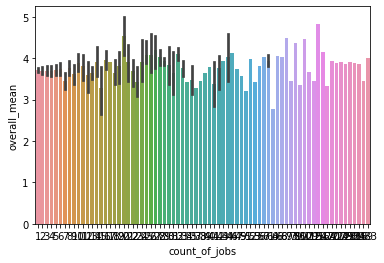

In [17]:
# See if companies with more job openings have better or worse overall ratings
sns.barplot(x='count_of_jobs', y='overall_mean', data=scaleScore_df)

# No major differences